Importing the models

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, RandomZoom, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import time

In [ ]:
#load the dataset
csv_path = Path("training.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(f"\nTotal rows: {len(df)}")

if not {"image", "choice"}.issubset(set(df.columns)):
  raise ValueError("CSV must have 'image' and 'choice' columns.")

print("\nClass counts:")
print(df["choice"].value_counts())


                              image  choice
0   ../frames/solve6/frame_0483.jpg  paused
1  ../frames/solve11/frame_0018.jpg  paused
2  ../frames/solve10/frame_0343.jpg  paused
3   ../frames/solve5/frame_0274.jpg  paused
4  ../frames/solve17/frame_0521.jpg  moving

Total rows: 9702

Class counts:
choice
moving    4889
paused    4813
Name: count, dtype: int64


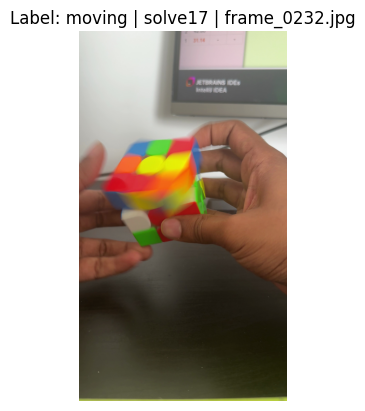

In [ ]:
#display a sample
df = pd.read_csv("training.csv")
row = df.sample(1).iloc[0]
img_path = row["image"]
label = row["choice"]
correct_path = img_path
solve = os.path.basename(os.path.dirname(img_path))
frame = os.path.basename(img_path)
img = Image.open(correct_path)
plt.imshow(img)
plt.title(f"Label: {label} | {solve} | {frame}")
plt.axis("off")
plt.show()

Spliting the dataset for traning, val and testing

In [ ]:
#split the dataset 
train_df, temp_df = train_test_split(
  df,
  test_size=0.2,
  stratify=df['choice'],
  random_state=42
)
val_df, test_df = train_test_split(
  temp_df,
  test_size=0.5,
  stratify=temp_df['choice'],
  random_state=42
)

#print
print(f"Train set: {len(train_df)} rows")
print(train_df['choice'].value_counts(normalize=True))
print(f"Validation set: {len(val_df)} rows")
print(val_df['choice'].value_counts(normalize=True))
print(f"Test set: {len(test_df)} rows")
print(test_df['choice'].value_counts(normalize=True))

#save
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

Train set: 7761 rows
choice
moving    0.50393
paused    0.49607
Name: proportion, dtype: float64
Validation set: 970 rows
choice
moving    0.504124
paused    0.495876
Name: proportion, dtype: float64
Test set: 971 rows
choice
moving    0.503605
paused    0.496395
Name: proportion, dtype: float64


In [ ]:
#encode class labels (0 for 'paused', 1 for 'moving')
mapping = {'paused': 0, 'moving': 1}
train_df['label'] = train_df['choice'].map(mapping)
val_df['label'] = val_df['choice'].map(mapping)
test_df['label'] = test_df['choice'].map(mapping)

Data augmentation

In [ ]:
#data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomBrightness(0.05),
    RandomContrast(0.05)
])

#load and augment
def load_and_augment(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = data_augmentation(img, training=True)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

#load and preprocess image for validation and testing
def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label

#re-create datasets with augmentation before batching
batch_size = 32
start = time.time()
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label']))
train_ds = train_ds.map(load_and_augment, num_parallel_calls=16)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
print(f"Train DS creation time: {time.time() - start}s")

val_ds = tf.data.Dataset.from_tensor_slices((val_df['image'], val_df['label']))
val_ds = val_ds.map(load_image, num_parallel_calls=16).batch(batch_size).prefetch(tf.data.AUTOTUNE)
print(f"Val DS creation time: {time.time() - start}s")

test_ds = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label']))
test_ds = test_ds.map(load_image, num_parallel_calls=16).batch(batch_size).prefetch(tf.data.AUTOTUNE)
print(f"Test DS creation time: {time.time() - start}s")

#verify dataset shape
for images, labels in train_ds.take(1):
    print("Train DS element spec:", images.shape)

Train DS creation time: 0.17081427574157715s
Val DS creation time: 0.19948410987854004s
Test DS creation time: 0.21257901191711426s
Train DS element spec: (32, 224, 224, 3)


2025-09-07 13:10:33.049449: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-09-06 12:56:48.007471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


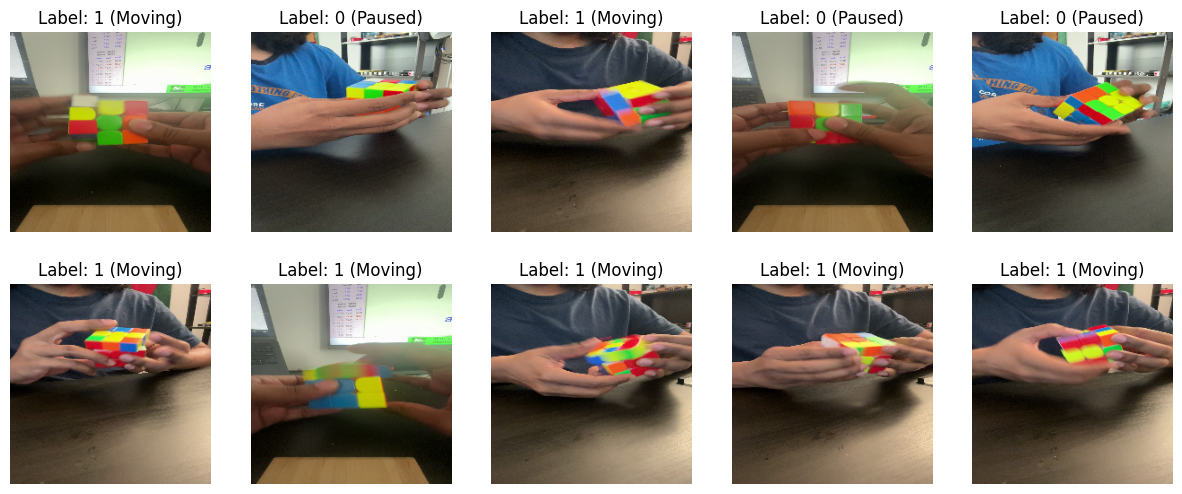

In [ ]:
#display sample images from validation dataset
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for batch in val_ds.take(1):
    images, labels = batch
    for i in range(10):
        row, col = divmod(i, 5)
        axs[row, col].imshow(images[i].numpy())
        axs[row, col].set_title(f"Label: {labels[i].numpy()} ({'Paused' if labels[i]==0 else 'Moving'})")
        axs[row, col].axis('off')
plt.show()

Model

In [ ]:
#define the MobileNetV2 model
def create_mobilenetv2_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])
    
    return model

model = create_mobilenetv2_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 1,370,433 (5.23 MB)

 Non-trainable params: 1,052,160 (4.01 MB)

In [ ]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

#callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, lr_scheduler]

#class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

#training
history = model.fit(train_ds, validation_data=val_ds, epochs=30, class_weight=class_weight_dict, callbacks=callbacks)

model.save(f'MobileNetV2_model2.keras')

#plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()